## Notebook description

This notebook demonstrates the customization of the reward function for the `highway-fast-v0 environment`. The custom reward logic is implemented in the `utils/highwayEnvCustomReward.py` file and replaces or enhances elements of the default reward function to better **align with realistic driving scenarios and enhance safety aspects**.

## Summary of the default reward function in `highway-fast-v0`

The default reward function in the highway-fast-v0 environment is designed to promote safe and efficient driving behaviors. It calculates a scalar reward for each action based on four key factors:

1. **Collision Penalty:**

   - The `collision_reward` penalizes the agent if the vehicle crashes. This is a binary penalty, either 0 (no crash) or a negative value (collision occurred).

2. **Right Lane Reward:**

   - The `right_lane_reward` rewards the agent for staying in the rightmost lane. The reward increases as the vehicle moves closer to the rightmost lane, encouraging proper lane usage.

3. **High-Speed Reward:**

   - The `high_speed_reward` incentivizes driving at higher speeds. The reward is proportional to the vehicle's forward speed, normalized within a defined speed range.

4. **On-Road Reward:**
   - The `on_road_reward` encourages the vehicle to stay on the road by multiplying the total reward by 1 if the vehicle is on the road or 0 if it is off-road. This means that if the vehicle is off-road, the total reward is also zero.

## Shortcomings of the default reward function in `highway-fast-v0`

1. **Overemphasising the rightmost lane:**

   - The `right_lane_reward` encourages staying in the rightmost lane, which may not be in line with realistic driving goals. For example, overtaking may require swerving into other lanes, which is not directly encouraged.

2. **Speed reward out of context:**

   - The `high_speed_reward` rewards speed linearly, but does not take into account traffic density. Speeding in traffic jams should be penalised.

3. **Binary Collision Penalty:**

   - The `collision_reward` is binary, providing the same penalty regardless of the severity or cause of the crash. This ignores scenarios like near-misses, which could be penalized slightly to encourage caution.

4. **Lack of a Safe Distance Mechanism:**

   - The current reward function does not provide an incentive to maintain a safe distance from the vehicle in front. However, promoting a safe following distance is a fundamental part of safe driving. It helps avoid collisions and creates smoother traffic flow.

## Changes made to the reward function

### Add safe distance reward

**Implementation**

1. Identify the Front Vehicle:

   - Use the existing `road.neighbour_vehicles(vehicle)` method to locate the vehicle ahead of the agent.

2. Compute the Distance:

   - Calculate the distance between the agent's vehicle and the identified front vehicle. If no front vehicle exists, assume the distance is infinite.

3. Define the Reward:

   - Reward the agent if the distance exceeds a safe threshold (e.g., 10 meters). Penalize the agent as the distance decreases below this threshold.

**Advantages**

- Encourages the agent to maintain a safe distance, reducing the likelihood of rear-end collisions.
- Promotes safer and more realistic driving behaviors.


---
**Code**

````python
# safe distance reward
front_vehicle, _ = self.road.neighbour_vehicles(self.vehicle) # identify the front vehicle
safe_distance = 5
if front_vehicle:
    distance = max(front_vehicle.position[0] - self.vehicle.position[0], 0)

    if distance > safe_distance:
        safe_distance_reward = 1  # Full reward if distance is safe
    else:
        safe_distance_reward = -1 * (safe_distance - distance) / safe_distance
else:
    safe_distance_reward = 0
````

---

### Improve existing collision reward

**Implementation**

1. Collision Penalty:
    - Check whether the agent's vehicle has crashed (self.vehicle.crashed).
    - Apply a fixed penalty of -1 if a collision has occurred; otherwise, no penalty is applied.

2. Near-Miss Penalty:
    - Iterate through all vehicles on the road and calculate the Euclidean distance between the agent's vehicle and other vehicles.
    - Define a "near-miss" threshold (e.g., 2 meters).
    - Apply a scaled penalty when the distance falls within the near-miss range (closer near-misses incur higher penalties).

3. Combine Penalties:
    - The total collision reward is the sum of the collision penalty and the near-miss penalties.

**Advantages**
- Encourages the agent to avoid collisions entirely by imposing a strict penalty.
- Promotes safer behavior by penalizing close interactions (near-misses), even when collisions are avoided.
- Improves realism in the simulation, as near-misses are indicative of risky driving.

---
**Code**

````python
# Improved collision reward
collision_penalty = 1 if self.vehicle.crashed else 0  # Full penalty for collision
near_miss_penalty = 0
for vehicle in self.road.vehicles:
    if vehicle is not self.vehicle:
        distance_to_vehicle = np.linalg.norm(
            np.array(self.vehicle.position) - np.array(vehicle.position)
        )
        if 0 < distance_to_vehicle <= 2:  # Near-miss threshold
            near_miss_penalty += -0.5 * (2 - distance_to_vehicle) / 2

collision_reward = collision_penalty + near_miss_penalty
````

---

### Add high speed reward

**Implementation**

1. Define Traffic Radius:
    - Set a traffic_radius (e.g., 10 meters) within which the agent's vehicle assesses the surrounding traffic density.

2. Count Nearby Vehicles:
    - Iterate through all vehicles on the road and calculate the Euclidean distance between the agent's vehicle and others.
    - Increment the count of nearby vehicles if they are within the defined traffic radius.

3. Compute Traffic Density Factor:
    - Use the number of nearby vehicles to calculate a traffic density factor, where higher traffic density reduces the reward.
    - Define a maximum density (max_density, e.g., 10 vehicles) for scaling. The factor decreases linearly as the density approaches this maximum.

4. Scale the High-Speed Reward:
    - Adjust the agent's speed-based reward (scaled_speed) using the traffic density factor.
    - Clip the reward within a range of 0 to 1 for consistency.

**Advantages**
- Encourages the agent to drive at higher speeds when traffic density is low, promoting efficient driving.
- Discourages risky high-speed driving in dense traffic, reducing the likelihood of collisions or unsafe maneuvers.

---
**Code**

````python
# high speed reward
traffic_radius = 10

# Count the number of vehicles within the traffic radius
nearby_vehicles = 0
for other_vehicle in self.road.vehicles:
    if other_vehicle is not self.vehicle:
        distance = np.linalg.norm(
            np.array(other_vehicle.position) - np.array(self.vehicle.position)
        )
        if distance < traffic_radius:
            nearby_vehicles += 1

# Traffic density factor: more vehicles -> higher penalty
max_density = 10
traffic_density_factor = max(0, 1 - nearby_vehicles / max_density)

# Adjust high-speed reward based on traffic density
high_speed_reward = np.clip(scaled_speed * traffic_density_factor, 0, 1)
````
---

### Add rule to discourage overtaking vehicles to the left of the car 

**Implementation**
1. Retrieve the vehicle horizontally closest and to the left to the ego vehicle.
2. Record the position of the left vehicle and the position of the ego vehicle.
3. In the following step, compare the position of the left vehicle and the ego vehicle to their recorded positions in the previous step.
4. If the left vehicle was ahead of the ego vehicle in the previous step, but behind the ego vehicle in the current step, the ego vehicle is considered to have overtaken the left vehicle, and is penalized.


**Advantages**
- Penalizing overtaking to the left aligns with traffic laws in regions where overtaking is legally allowed only on the right (e.g., in countries with right-hand traffic).



---
**Code**

```python
ego_vehicle = self.vehicle

ego_current_position = ego_vehicle.position[0]
left_vehicle = self.get_closest_left_vehicle( ego_vehicle)
car_overtook_left_vehicle = False

if (left_vehicle):
    left_current_position = left_vehicle.position[0]

ego_previous_position_exists =hasattr(self, "ego_vehicle_previous_position") and (self.ego_vehicle_previous_position is not None)
left_previous_position_exists =hasattr(self, "left_vehicle_previous_position") and (self.left_vehicle_previous_position is not None)
        
if left_vehicle and ego_previous_position_exists and left_previous_position_exists:
    left_vehicle_was_ahead_of_ego = ~(self.ego_vehicle_previous_position > self.left_vehicle_previous_position)
    left_vehicle_now_behind_ego = ego_current_position > left_current_position
    car_overtook_left_vehicle = (left_vehicle_was_ahead_of_ego and left_vehicle_now_behind_ego)
    
self.ego_vehicle_previous_position = ego_current_position
# Reset previous position if no left car
if left_vehicle is None:
    self.left_vehicle_previous_position = None
else: 
    self.left_vehicle_previous_position = left_vehicle.position[0]
    
if (car_overtook_left_vehicle):
    return 1
return 0
```


## Evaluate the custom reward function

We evaluate the performance of our custom reward function by comparing it to the default reward function. During the model evaluation process, rewards are logged to a CSV file, capturing the values of various reward components. At the end of the evaluation, we sum up the logged rewards from both the custom and default reward functions and compare the results to assess the effectiveness of the custom function in achieving the desired outcomes (safety and real-world driving rules).

In [2]:
import highway_env
from gymnasium import register
import gymnasium
import csv
from collections import defaultdict
from utils.training import train_model
from utils.evaluation import evaluate_model

In [12]:
def aggregate_and_normalize_rewards(file_path):
    """
    Read and aggregate rewards from the CSV file, then normalize by the number of steps.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - dict: Dictionary of normalized rewards (average reward per step).
    """
    rewards_summary = defaultdict(float)
    total_steps = 0  # Count the number of rows (steps)

    try:
        with open(file_path, mode='r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                total_steps += 1  # Increment step count for each row
                for key, value in row.items():
                    rewards_summary[key] += float(value)
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")
        return None

    # Normalize rewards by total steps
    if total_steps > 0:
        normalized_rewards = {key: value / total_steps for key, value in rewards_summary.items()}
    else:
        print("Error: No steps logged in the file.")
        return None

    return normalized_rewards


### Default reward function
First, we evaluate the performance using the default reward function.

In [4]:
register(
    id='DefaultRewardEnv',
    entry_point='HighwayEnvDefaultReward:HighwayEnvDefaultReward',
)

# Set log_rewards_enabled to True or False as per your requirement
log_rewards_enabled = False

# Create the environment with the custom parameter
env = gymnasium.make('DefaultRewardEnv', render_mode='rgb_array', log_rewards_enabled=log_rewards_enabled)

In [6]:
# train the model with the default reward function
train_model(
    env=env,
    session_name="default_reward_function",
)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 30,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 5,
 'vehicles_count': 20,
 'vehicles_density': 1}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/tensorboard/default_reward_function_DQN_Training\DQN_2
----------------------------------
| rollout

In [5]:
env = gymnasium.make('DefaultRewardEnv', render_mode='rgb_array', log_rewards_enabled=log_rewards_enabled)

# evaluate the model with the default reward function
evaluate_model(
    env=env,
    model_path="models/default_reward_function",
    algorithm='DQN',
)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 30,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 5,
 'vehicles_count': 20,
 'vehicles_density': 1}


In [13]:
# Path to the CSV file where rewards are logged
reward_log_path = 'default_reward_log.csv'

# Aggregate and normalize rewards
normalized_rewards = aggregate_and_normalize_rewards(reward_log_path)

if normalized_rewards:
    print("Normalized Rewards (Average Per Step):")
    for reward_type, avg_reward in normalized_rewards.items():
        print(f"{reward_type}: {avg_reward:.4f}")

Normalized Rewards (Average Per Step):
collision_reward: 0.1227
right_lane_reward: 0.4966
high_speed_reward: 0.8973
on_road_reward: 1.0000
safe_distance_reward: 0.8981
left_vehicle_overtaken_reward: 0.1135


### Custom reward function

Next, we evaluate the performance using our custom reward function.

In [7]:
# Register the custom environment
register(
    id='CustomRewardEnv',
    entry_point='HighwayEnvCustomReward:HighwayEnvFastCustomReward',
)

# Set log_rewards_enabled to True or False as per your requirement
log_rewards_enabled = False

# Create the environment with the custom parameter
env = gymnasium.make('CustomRewardEnv', render_mode='rgb_array', log_rewards_enabled=log_rewards_enabled)

# Configuration updates for the environment
config_updates = {
    "safe_distance_reward": 0.1,
    "left_vehicle_overtaken_reward": -0.5,
    "collision_reward": -4,
}

In [8]:
# Start training with the updated environment
train_model(
    env=env,
    config_updates=config_updates,
    session_name="custom_reward_function",
)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -4,
 'controlled_vehicles': 1,
 'duration': 30,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'left_vehicle_overtaken_reward': -0.5,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'safe_distance_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 5,
 'vehicles_count': 20,
 'vehicles_density': 1}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/tensorboard/custom_reward_fun

In [10]:
# evaluate the model with the custom reward function
env = gymnasium.make('CustomRewardEnv', render_mode='rgb_array', log_rewards_enabled=log_rewards_enabled)

# Configuration updates for the environment
config_updates = {
    "safe_distance_reward": 0.1,
    "left_vehicle_overtaken_reward": -0.5,
    "collision_reward": -4,
}

# evaluate the model with the default reward function
evaluate_model(
    env=env,
    config_updates=config_updates,
    model_path="models/custom_reward_function",
    algorithm='DQN',
)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -4,
 'controlled_vehicles': 1,
 'duration': 30,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'left_vehicle_overtaken_reward': -0.5,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'safe_distance_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 5,
 'vehicles_count': 20,
 'vehicles_density': 1}


In [14]:
# Path to the CSV file where rewards are logged
reward_log_path = 'custom_reward_log.csv'

# Aggregate and normalize rewards
normalized_rewards = aggregate_and_normalize_rewards(reward_log_path)

if normalized_rewards:
    print("Normalized Rewards (Average Per Step):")
    for reward_type, avg_reward in normalized_rewards.items():
        print(f"{reward_type}: {avg_reward:.4f}")

Normalized Rewards (Average Per Step):
collision_reward: 0.0087
right_lane_reward: 0.4972
high_speed_reward: 0.1130
on_road_reward: 1.0000
safe_distance_reward: 0.9932
left_vehicle_overtaken_reward: 0.0151


### Default Reward Function

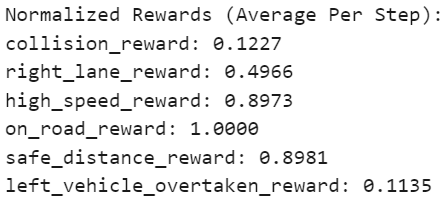


### Custom Reward Function

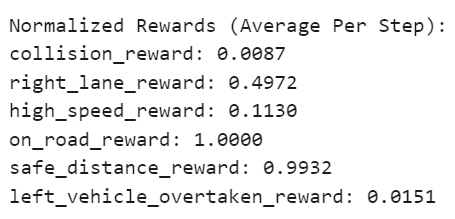